In [1]:
from skimage import io
from skimage.color import rgb2gray
from deskew import determine_skew
from deskew import determine_skew_dev

image = io.imread("../tests/deskew-3.png")

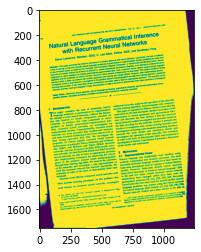

In [2]:
from matplotlib import pyplot as plt
plt.imshow(image)

[[False False False ... False False False]
 [False False  True ... False False False]
 [False  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(1748, 1241)


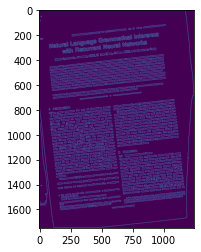

In [3]:
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks

edges = canny(image, sigma=3.0)
print(edges)
print(edges.shape)
plt.imshow(edges)

In [4]:
from skimage.transform import hough_line
out, angles, distances = hough_line(edges, np.linspace(-np.pi / 2, np.pi / 2, 1800, endpoint=False))

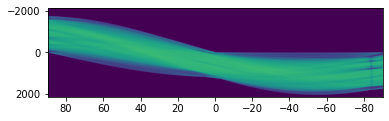

In [5]:
plt.imshow(
    np.log(1 + out),
    extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), distances[-1], distances[0]],
    aspect=1.0 / 90,
)

In [6]:
import numpy as np
_, angles_peaks, _ = hough_line_peaks(out, angles, distances, num_peaks=20, threshold=0.05 * np.max(out))
print(len(angles_peaks))
print(angles_peaks)

20
[ 0.         -1.57079633 -0.1134464   1.46258591  1.46084058  1.45909525
  1.46433124  1.46084058  1.46433124  1.46258591  1.46084058  1.46433124
  1.46258591  1.46084058  1.46258591  1.45909525  1.46084058  1.46084058
  1.45909525  1.46258591]


[0.0, -90.0, -6.49999999999999, 83.8, 83.7, 83.60000000000002, 83.89999999999999, 83.7, 83.89999999999999, 83.8, 83.7, 83.89999999999999, 83.8, 83.7, 83.8, 83.60000000000002, 83.7, 83.7, 83.60000000000002, 83.8]


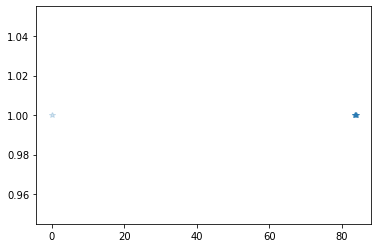

In [7]:

def _calculate_deviation(angle: float) -> np.float64:

    angle_in_degrees = np.abs(angle)
    deviation: np.float64 = np.abs(np.pi / 4 - angle_in_degrees)

    return deviation

absolute_deviations = [_calculate_deviation(k) for k in angles_peaks]
average_deviation: np.float64 = np.mean(np.rad2deg(absolute_deviations))
angles_peaks_degree = [np.rad2deg(x) for x in angles_peaks]
print(angles_peaks_degree)

import matplotlib.pyplot as plt
plt.plot([e%90 for e in angles_peaks_degree], [1 for _ in angles_peaks_degree], '*', alpha=0.1)

In [8]:
from typing import TYPE_CHECKING, Any, Dict, List, Optional, Tuple

def _get_max_freq_elem(peaks: List[int]) -> List[float]:
    freqs: Dict[float, int] = {}
    for peak in peaks:
        if peak in freqs:
            freqs[peak] += 1
        else:
            freqs[peak] = 1

    sorted_keys = sorted(freqs.keys(), key=freqs.get, reverse=True)  # type: ignore
    max_freq = freqs[sorted_keys[0]]

    max_arr = []
    for sorted_key in sorted_keys:
        if freqs[sorted_key] == max_freq:
            max_arr.append(sorted_key)

    return max_arr

def _compare_sum(value: float) -> bool:
    return 44 <= value <= 46

bin_0_45 = []
bin_45_90 = []
bin_0_45n = []
bin_45_90n = []

for angle in angles_peaks_degree:

    deviation_sum = int(90 - angle + average_deviation)
    if _compare_sum(deviation_sum):
        bin_45_90.append(angle)
        continue

    deviation_sum = int(angle + average_deviation)
    if _compare_sum(deviation_sum):
        bin_0_45.append(angle)
        continue

    deviation_sum = int(-angle + average_deviation)
    if _compare_sum(deviation_sum):
        bin_0_45n.append(angle)
        continue

    deviation_sum = int(90 + angle + average_deviation)
    if _compare_sum(deviation_sum):
        bin_45_90n.append(angle)

angles = [bin_0_45, bin_45_90, bin_0_45n, bin_45_90n]
nb_angles_max = 0
max_angle_index = -1
for angle_index, angle in enumerate(angles):
    nb_angles = len(angle)
    if nb_angles > nb_angles_max:
        nb_angles_max = nb_angles
        max_angle_index = angle_index

if nb_angles_max:
    ans_arr = _get_max_freq_elem(angles[max_angle_index])
    angle = np.mean(ans_arr)
elif angles_peaks_degree:
    ans_arr = _get_max_freq_elem(angles_peaks_degree)
    angle = np.mean(ans_arr)
else:
    print(None, angles, average_deviation)

if 0 <= angle <= 90:
    rot_angle = angle - 90
elif -45 <= angle < 0:
    rot_angle = angle - 90
elif -90 <= angle < -45:
    rot_angle = 90 + angle

import matplotlib.pyplot as plt
print(rot_angle, angles, average_deviation)

-6.299999999999997 [[], [83.8, 83.7, 83.60000000000002, 83.89999999999999, 83.7, 83.89999999999999, 83.8, 83.7, 83.89999999999999, 83.8, 83.7, 83.8, 83.60000000000002, 83.7, 83.7, 83.60000000000002, 83.8], [-6.49999999999999], []] 39.36000000000001
